# Hyper-parameters Optimization for Electricity Load Forecasting

In this notebook, we demonstrate how to carry out hyperparameter optimization using a deep learning forecasting model in order to accurately forecast electricity loads with confidence intervals. 

We will work with [this dataset](https://archive.ics.uci.edu/ml/datasets/ElectricityLoadDiagrams20112014) (readily available in `darts.datasets`), which contains measurements of the electricity consumption for 370 clients of a Portuguese energy company, obtained with a 15 minutes frequency. We will attempt to forecast over a horizon of 2 weeks. At this frequency, this means we attempt to forecast 2,688 time steps in the future. This is a quite demanding requirements, and we will try to find a *good* model to do this.

We will use the open-source [Optuna library](https://optuna.org/) for the hyperparameter optimization, and Darts' [TCN Model](https://unit8co.github.io/darts/generated_api/darts.models.forecasting.tcn_model.html) (see [here](https://unit8.com/resources/temporal-convolutional-networks-and-forecasting/) for an introductory article to this model). This model employs dilated convolutions, which work great when capturing such high frequency series (15 minutes) over long periods (multiple weeks), while keeping a small overall model size.

It is recommended to have a GPU to run this notebook, although all of the concepts apply irrespective of whether the models run on CPU or GPU.

First, we install and import what we need:

In [ ]:
# necessary packages:
!pip install -U darts
!pip install -U optuna

In [1]:
%matplotlib inline

import optuna
from optuna.integration import PyTorchLightningPruningCallback
from optuna.visualization import (
    plot_optimization_history,
    plot_contour,
    plot_param_importances,
)
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from pytorch_lightning.callbacks import Callback, EarlyStopping
from sklearn.preprocessing import MaxAbsScaler

from darts.datasets import ElectricityDataset
from darts.models import TCNModel, LinearRegressionModel
from darts.dataprocessing.transformers import Scaler
from darts.metrics import smape
from darts.utils.likelihood_models import GaussianLikelihood

## Data Preparation

The following cell can take a few minutes to execute. It'll download about 250 MB of data from the Internet. We specify `multivariate=False`, so we get a list of 370 *univariate* `TimeSeries`. We could also have specified `multivariate=True` to obtain one *multivariate* `TimeSeries` containing 370 components.

In [2]:
all_series = ElectricityDataset(multivariate=False).load()

  0%|          | 0/370 [00:00<?, ?it/s]

We keep the last 80 days for each series, and cast all of them to float32:

In [3]:
NR_DAYS = 80
DAY_DURATION = 24 * 4  # 15 minutes frequency

all_series_fp32 = [
    s[-(NR_DAYS * DAY_DURATION) :].astype(np.float32) for s in tqdm(all_series)
]

  0%|          | 0/370 [00:00<?, ?it/s]

We have 370 univariate `TimeSeries`, each with a frequency of 15 minutes. In what follows, we will be training a single global model on all of them.

First, we create our training set. We set aside the last 14 days as test set, and the 14 days before that as validation set (which will be used for hyperparameter optimization).

Note that the `val` and `test` sets below only contain the 14-days "forecast evaluation" parts of the series. Throughout the notebook, we'll evaluate how accurate some 14-days forecasts are over `val` (or `test`). However, to produce these 14-days forecasts, our models will consume a certain lookback window `in_len` worth of time stamps. For this reason, below we will also create validation sets that include these extra `in_len` points (as `in_len` is a hyper-parameter itself, we create these longer validation sets dynamically); it will be mainly useful for early-stopping.

In [4]:
# Split in train/val/test
val_len = 14 * DAY_DURATION  # 14 days

train = [s[: -(2 * val_len)] for s in all_series_fp32]
val = [s[-(2 * val_len) : -val_len] for s in all_series_fp32]
test = [s[-val_len:] for s in all_series_fp32]

# Scale so that the largest value is 1.
# This way of scaling perserves the sMAPE
scaler = Scaler(scaler=MaxAbsScaler())
train = scaler.fit_transform(train)
val = scaler.transform(val)
test = scaler.transform(test)

Let's plot a few of our series:

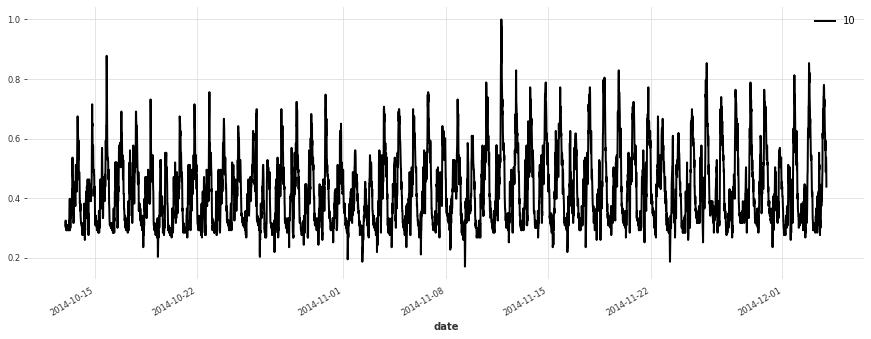

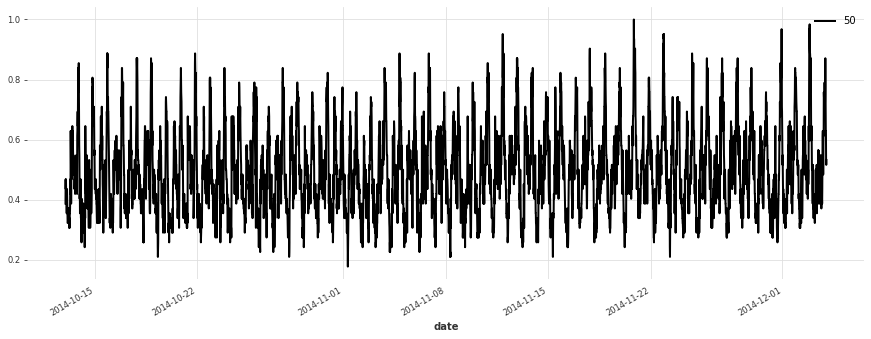

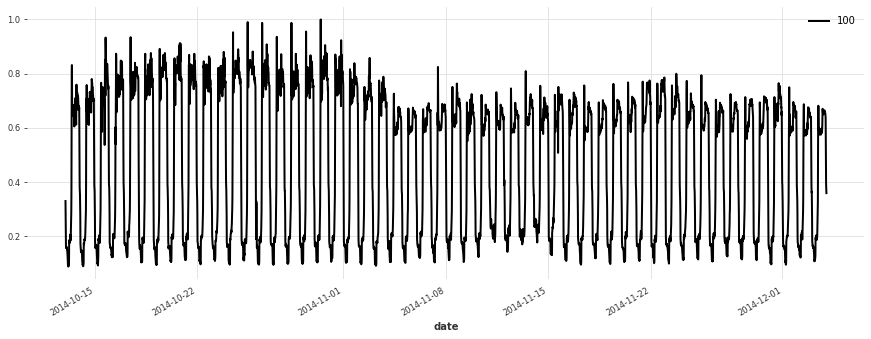

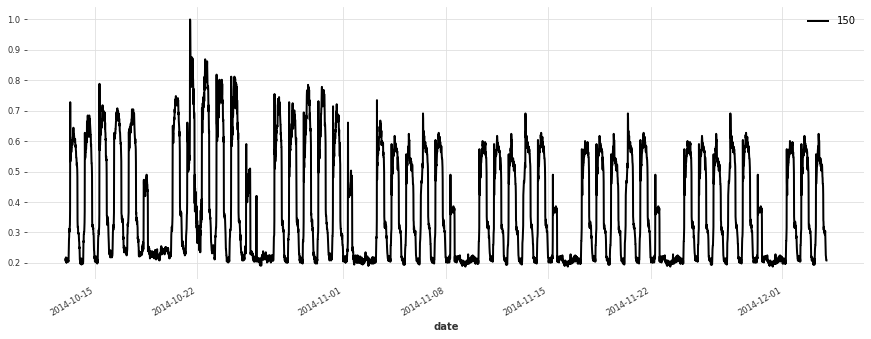

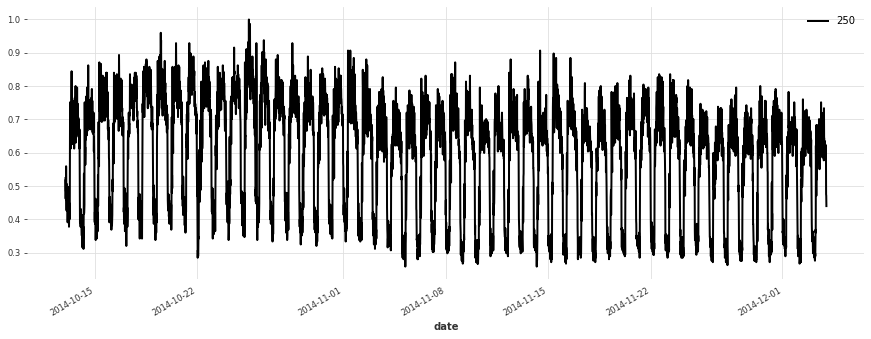

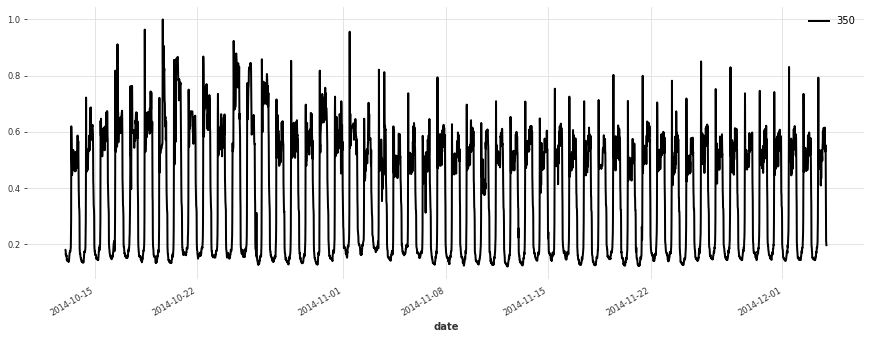

In [5]:
for i in [10, 50, 100, 150, 250, 350]:
    plt.figure(figsize=(15, 5))
    train[i].plot(label="{}".format(i, lw=1))

## Build a Simple Linear Model

We start off without any hyperparameter optimization, and try a simple linear regression model first. It will serve as a baseline. In this model, we use a lookback window of 1 week.

**Note:** doing significantly better than linear regression is often not trivial! We recommend to always consider at least one such reasonably simple baseline first, before jumping to more complex models.

`LinearRegressionModel` wraps around `sklearn.linear_model.LinearRegression`, which may take a significant amount of processing and memory. Running this cell takes a couple of minutes, and we recommend skipping it unless you have at least 20GB of RAM on your system.

In [6]:
lr_model = LinearRegressionModel(lags=7 * DAY_DURATION)
lr_model.fit(train);

Let's see how this model is doing:

linear regression sMAPE: 16.01 +- 20.59


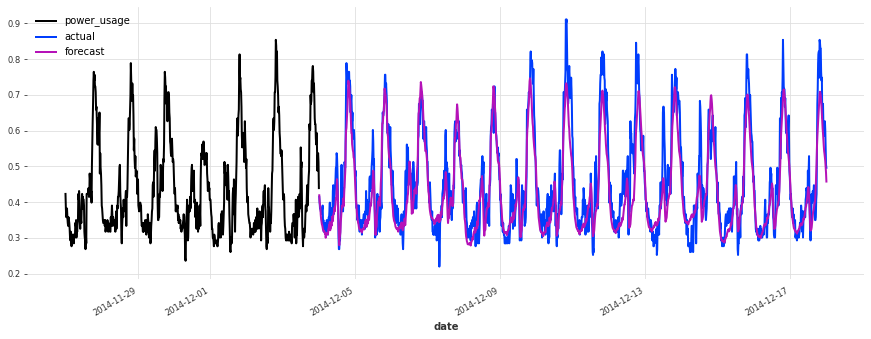

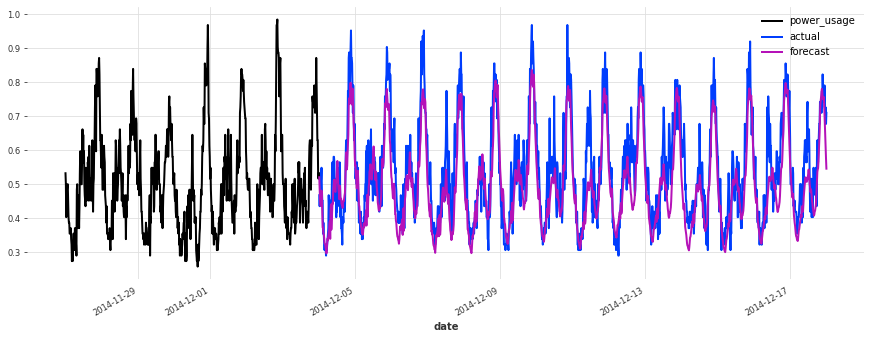

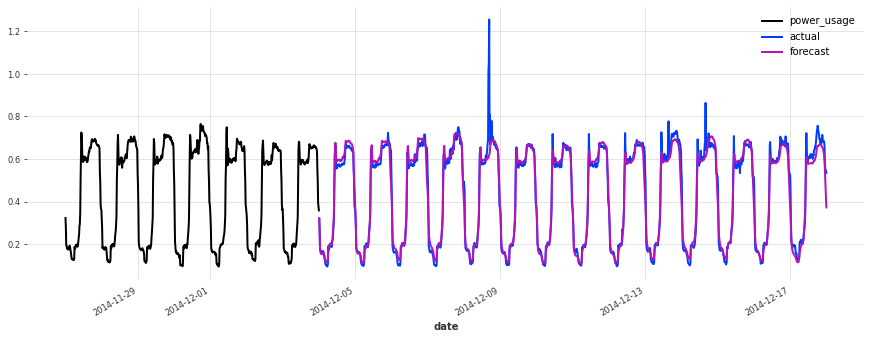

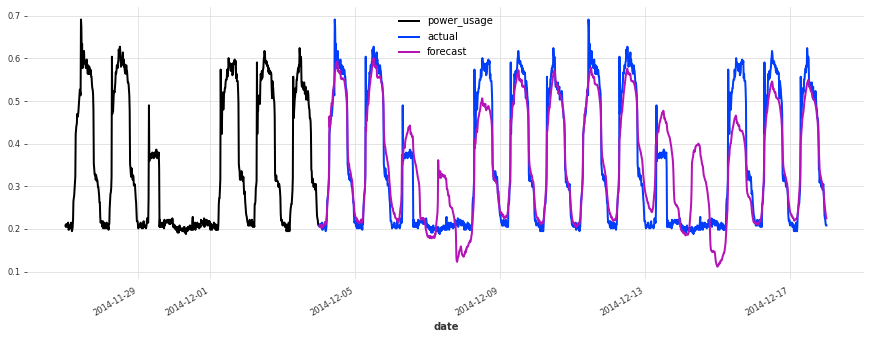

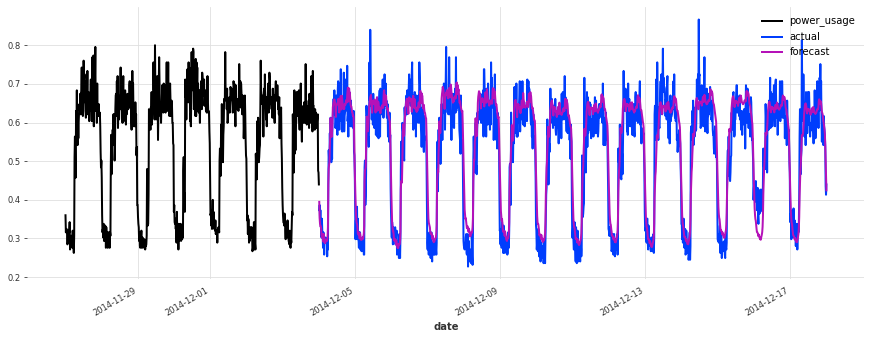

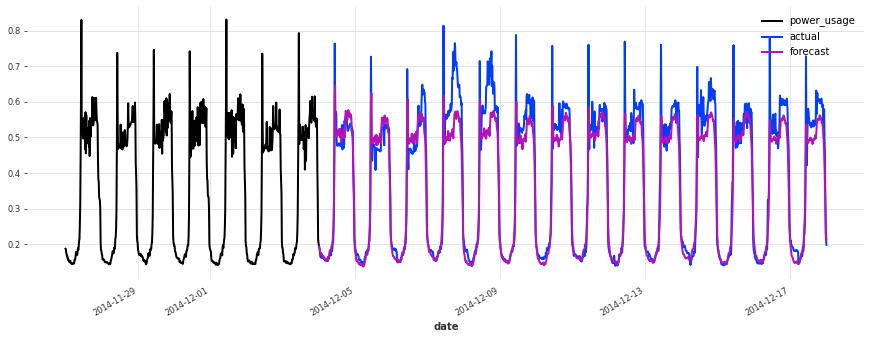

In [7]:
def eval_model(preds, name, train_set=train, val_set=val):
    smapes = smape(preds, val_set)
    print("{} sMAPE: {:.2f} +- {:.2f}".format(name, np.mean(smapes), np.std(smapes)))

    for i in [10, 50, 100, 150, 250, 350]:
        plt.figure(figsize=(15, 5))
        train_set[i][-7 * DAY_DURATION :].plot()
        val_set[i].plot(label="actual")
        preds[i].plot(label="forecast")


lr_preds = lr_model.predict(series=train, n=val_len)
eval_model(lr_preds, "linear regression")

This model is already doing quite well out of the box! Let's see now if we can do better using deep learning.

## Build a Simple TCN Model
We now build a [TCN model](https://unit8co.github.io/darts/generated_api/darts.models.forecasting.tcn_model.html) with some simple choice of hyperparameters, but without any hyperparameter optimization.

In [8]:
""" We write a function to build and fit a TCN Model, which we will re-use later.
"""


def build_fit_tcn_model(
    in_len,
    out_len,
    kernel_size,
    num_filters,
    weight_norm,
    dilation_base,
    dropout,
    lr,
    include_dayofweek,
    likelihood=None,
    callbacks=None,
):

    # reproducibility
    torch.manual_seed(42)

    # some fixed parameters that will be the same for all models
    BATCH_SIZE = 1024
    MAX_N_EPOCHS = 30
    NR_EPOCHS_VAL_PERIOD = 1
    MAX_SAMPLES_PER_TS = 1000

    # throughout training we'll monitor the validation loss for early stopping
    early_stopper = EarlyStopping("val_loss", min_delta=0.001, patience=3, verbose=True)
    if callbacks is None:
        callbacks = [early_stopper]
    else:
        callbacks = [early_stopper] + callbacks

    # detect if a GPU is available
    if torch.cuda.is_available():
        pl_trainer_kwargs = {
            "accelerator": "gpu",
            "gpus": -1,
            "auto_select_gpus": True,
            "callbacks": callbacks,
        }
        num_workers = 4
    else:
        pl_trainer_kwargs = {"callbacks": callbacks}
        num_workers = 0

    # optionally also add the day of the week (cyclically encoded) as a past covariate
    encoders = {"cyclic": {"past": ["dayofweek"]}} if include_dayofweek else None

    # build the TCN model
    model = TCNModel(
        input_chunk_length=in_len,
        output_chunk_length=out_len,
        batch_size=BATCH_SIZE,
        n_epochs=MAX_N_EPOCHS,
        nr_epochs_val_period=NR_EPOCHS_VAL_PERIOD,
        kernel_size=kernel_size,
        num_filters=num_filters,
        weight_norm=weight_norm,
        dilation_base=dilation_base,
        dropout=dropout,
        optimizer_kwargs={"lr": lr},
        add_encoders=encoders,
        likelihood=likelihood,
        pl_trainer_kwargs=pl_trainer_kwargs,
        model_name="tcn_model",
        force_reset=True,
        save_checkpoints=True,
    )

    # when validating during training, we can use a slightly longer validation
    # set which also contains the first input_chunk_length time steps
    model_val_set = scaler.transform(
        [s[-((2 * val_len) + in_len) : -val_len] for s in all_series_fp32]
    )

    # train the model
    model.fit(
        series=train,
        val_series=model_val_set,
        max_samples_per_ts=MAX_SAMPLES_PER_TS,
        dataloader_kwargs={"num_workers": num_workers},
    )

    # reload best model over course of training
    model = TCNModel.load_from_checkpoint("tcn_model")

    return model

In [ ]:
model = build_fit_tcn_model(
    in_len=7 * DAY_DURATION,
    out_len=6 * DAY_DURATION,
    kernel_size=5,
    num_filters=5,
    weight_norm=False,
    dilation_base=2,
    dropout=0.2,
    lr=1e-3,
    include_dayofweek=True,
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

First TCN model sMAPE: 16.94 +- 20.03


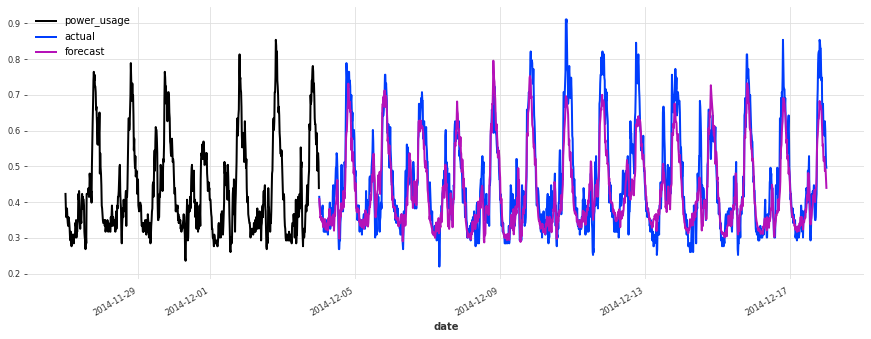

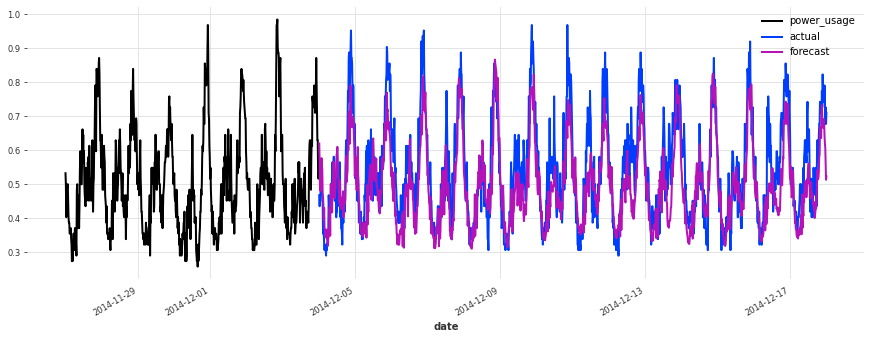

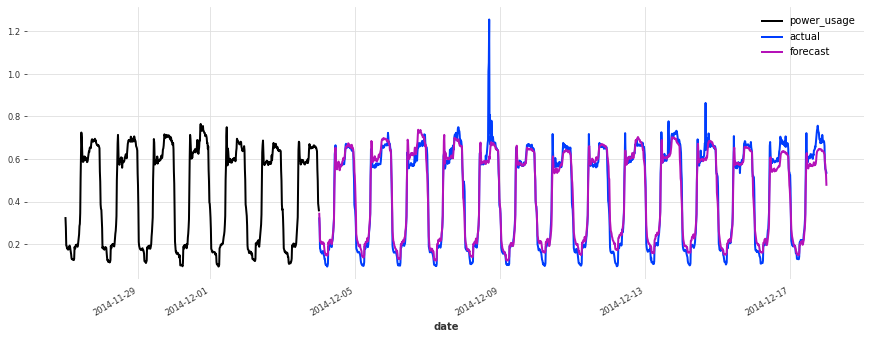

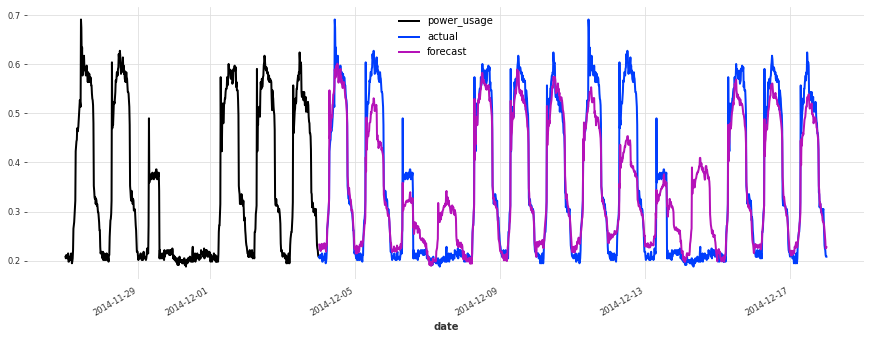

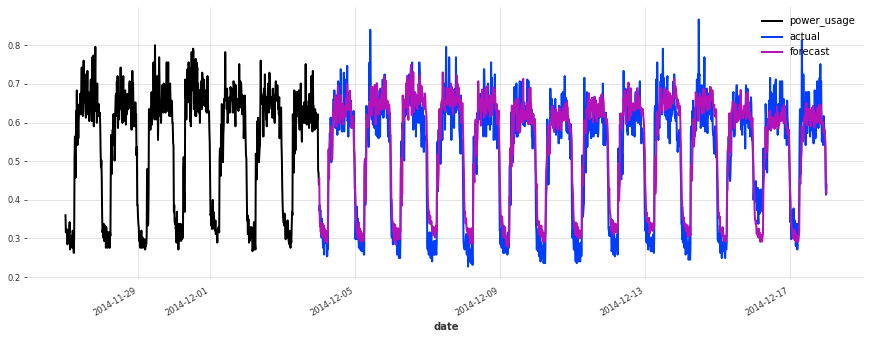

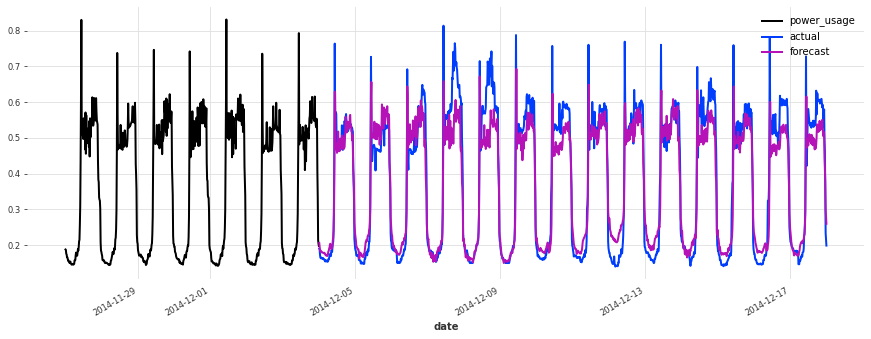

In [10]:
preds = model.predict(series=train, n=val_len)
eval_model(preds, "First TCN model")

Above, we built a first TCN model without any hyper-parameter search, and got an sMAPE of about 17%. Although this model looks like a good start (performing quite well on some of the series), it's not as good as the simple linear regression.

We can certainly do better, because there are many parameters that we have fixed but could have a large impact on performance, such as:

* The architecture of the network (number of filters, dilation size, kernel size, etc...)
* The learning rate
* Whether to use weight normalization and/or the dropout rate
* The length of the lookback and lookforward windows
* Whether to add calendar covariates, such as day-of-the-week
* ...


### One Option: using `gridsearch()`

One way to try and optimize these hyper-parameters is to try all combinations (assuming we have discretized our parameters). Darts offers a `gridsearch()` method to do just that. The advantage is that it is very simple to use. However, it also has severe drawbacks:

* It takes exponential time in the number of hyper-parameters: grid-searching over any non-trivial number of hyperparameters thus quickly becomes intractable.
* Gridsearch is naive: it does not attempt to pay attention to regions of the hyperparameter space that are more promising than others. It is limited points in the pre-defined grid.
* Finally, for simplicity reasons the Darts `gridsearch()` method is (at least at the time of writing) limited to working on one time series only.

For all these reasons, for any serious hyperparameter search, we need better techniques than grid-search. Fortunately, there are some great tools out there to help us.

## Using Optuna

[Optuna](https://optuna.org/) is a very nice open-source library for hyperparameter optimization. It's based on ideas such as Bayesian optimization, which balance exploration (of the hyperparameter space) with exploitation (namely, exploring more the parts of the space that look more promising). It can also use pruning in order to stop unpromising experiments early.

It's very easy to make it work: Optuna will take care of suggesting (sampling) hyper-parameters for us, and more or less all we need to do is to compute the objective value for a set of hyperparameters. In our case it consists in using these hyperparameters to build a model, train it, and report the obtained validation accuracy. We also setup a PyTorch Lightning pruning callback in order to early-stop unpromising experiments. All of this is done in the `objective()` function below.

In [16]:
def objective(trial):
    callback = [PyTorchLightningPruningCallback(trial, monitor="val_loss")]

    # set input_chunk_length, between 5 and 14 days
    days_in = trial.suggest_int("days_in", 5, 14)
    in_len = days_in * DAY_DURATION

    # set out_len, between 1 and 13 days (it has to be strictly shorter than in_len).
    days_out = trial.suggest_int("days_out", 1, days_in - 1)
    out_len = days_out * DAY_DURATION

    # Other hyperparameters
    kernel_size = trial.suggest_int("kernel_size", 5, 25)
    num_filters = trial.suggest_int("num_filters", 5, 25)
    weight_norm = trial.suggest_categorical("weight_norm", [False, True])
    dilation_base = trial.suggest_int("dilation_base", 2, 4)
    dropout = trial.suggest_float("dropout", 0.0, 0.4)
    lr = trial.suggest_float("lr", 5e-5, 1e-3, log=True)
    include_dayofweek = trial.suggest_categorical("dayofweek", [False, True])

    # build and train the TCN model with these hyper-parameters:
    model = build_fit_tcn_model(
        in_len=in_len,
        out_len=out_len,
        kernel_size=kernel_size,
        num_filters=num_filters,
        weight_norm=weight_norm,
        dilation_base=dilation_base,
        dropout=dropout,
        lr=lr,
        include_dayofweek=include_dayofweek,
        callbacks=callback,
    )

    # Evaluate how good it is on the validation set
    preds = model.predict(series=train, n=val_len)
    smapes = smape(val, preds, n_jobs=-1, verbose=True)
    smape_val = np.mean(smapes)

    return smape_val if smape_val != np.nan else float("inf")

Now that we have specified our objective, all we need to do is create an Optuna study, and run the optimization. We can either ask Optuna to run for a specified period of time (as we do here), or a certain number of trials. Let's run the optimization for a couple of hours:

In [ ]:
def print_callback(study, trial):
    print(f"Current value: {trial.value}, Current params: {trial.params}")
    print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")


study = optuna.create_study(direction="minimize")

study.optimize(objective, timeout=7200, callbacks=[print_callback])

# We could also have used a command as follows to limit the number of trials instead:
# study.optimize(objective, n_trials=100, callbacks=[print_callback])

# Finally, print the best value and best hyperparameters:
print(f"Best value: {study.best_value}, Best params: {study.best_trial.params}")

Note: If we wanted to optimize further, we could still call `study.optimize()` more times to resume where we left off

There's a lot more that you can do with Optuna. We refer to [the documentation](https://optuna.readthedocs.io/en/stable/index.html) for more information. For instance, it's possible to obtain useful insights into the optimization process, by visualising the objective value history (over trials), the objective value as a function of some of the hyperparameters, or the overall importance of some of the hyperparameters. 

In [16]:
plot_optimization_history(study)

In [18]:
plot_contour(study, params=["lr", "num_filters"])

In [19]:
plot_param_importances(study)

## Picking up the best model

After running the hyperparameter optimization for a couple of hours on a GPU, we got:

```
Best value: 14.720555851487694, Best params: {'days_in': 14, 'days_out': 6, 'kernel_size': 19, 'num_filters': 19, 'weight_norm': True, 'dilation_base': 4, 'dropout': 0.07718156729165897, 'lr': 0.0008841998396117885, 'dayofweek': False}
```

We can now take these hyperparameters and train the "best" model again. This time, we will directly try to fit a probabilistic model (using a Gaussian likelihood). Note that this actually changes the loss, so we're hoping that our hyperparameters are not too sensitive in that regard.

In [ ]:
best_model = build_fit_tcn_model(
    in_len=14 * DAY_DURATION,
    out_len=6 * DAY_DURATION,
    kernel_size=19,
    num_filters=19,
    weight_norm=True,
    dilation_base=4,
    dropout=0.0772,
    lr=0.0008842,
    likelihood=GaussianLikelihood(),
    include_dayofweek=False,
)

Let's now look at the accuracy of stochastic forecasts, with 100 samples:

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

best model, probabilistic sMAPE: 15.21 +- 19.76


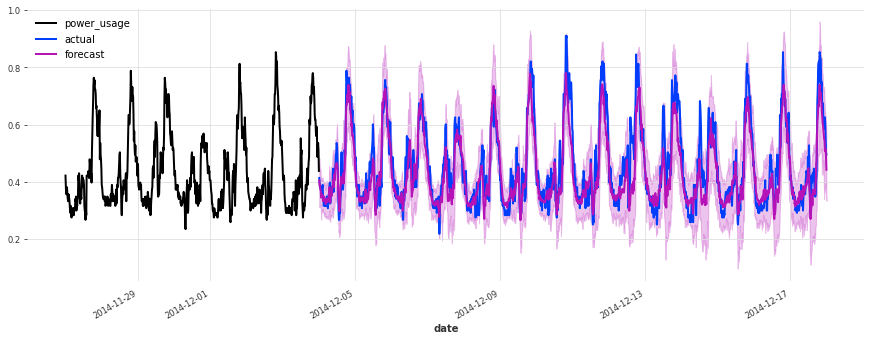

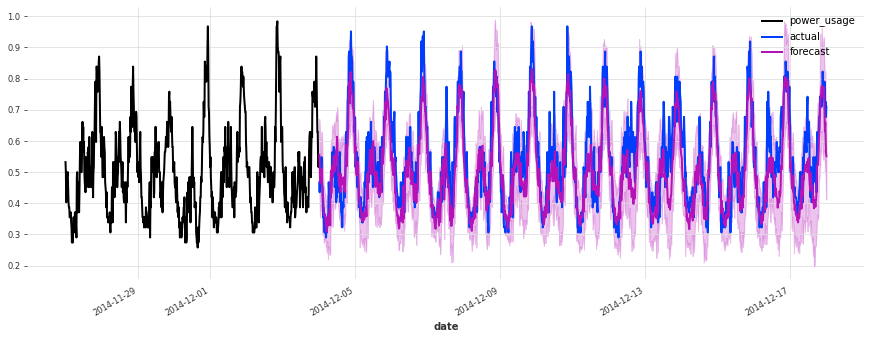

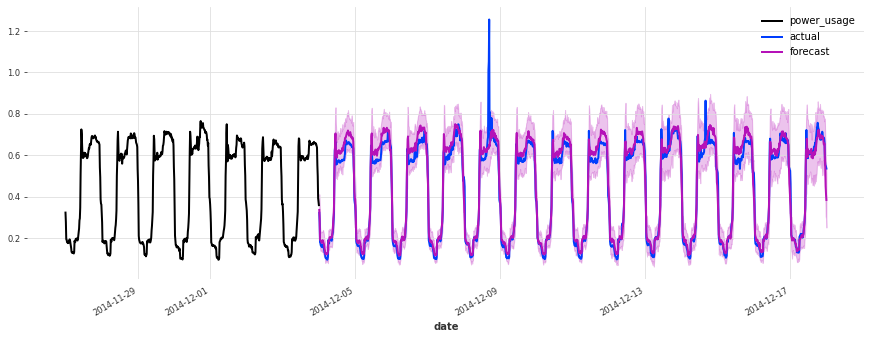

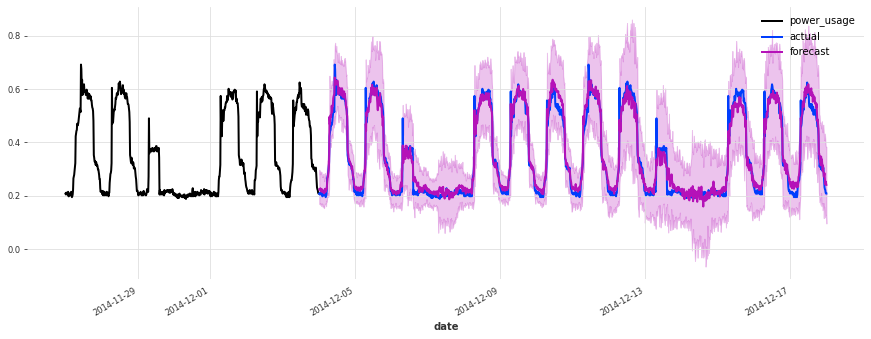

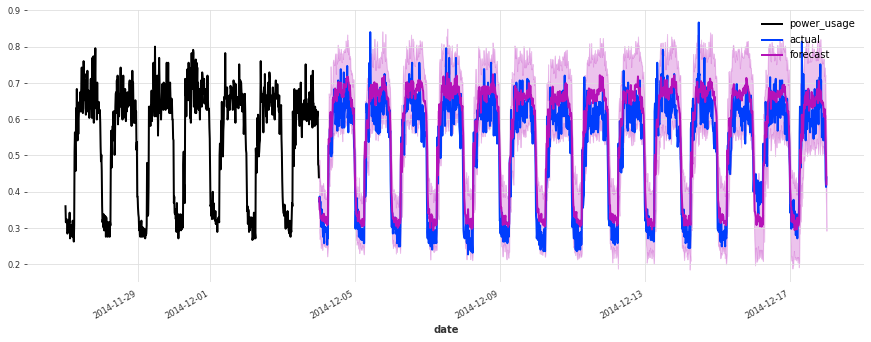

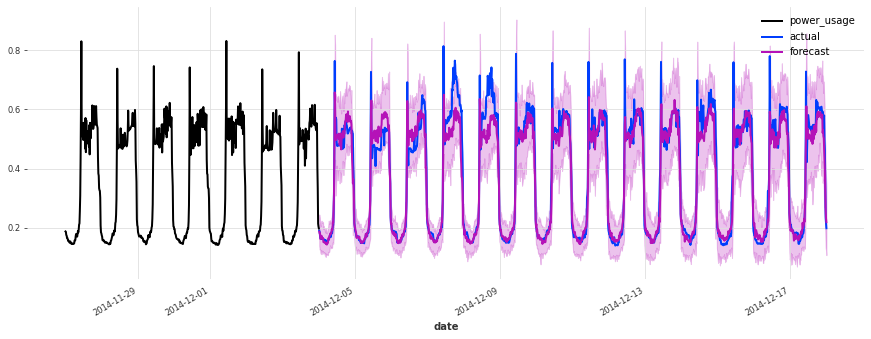

In [51]:
best_preds = best_model.predict(
    series=train, n=val_len, num_samples=100, mc_dropout=True
)
eval_model(best_preds, "best model, probabilistic")

The accuracy seems really good, and this model does not suffer from some of the same issues that our initial linear regression and early TCN had (look for instance in the failure modes it used to have on series 150). 

Let's now also see how it performs on the test set:

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

best model, probabilistic, on test set sMAPE: 19.21 +- 21.43


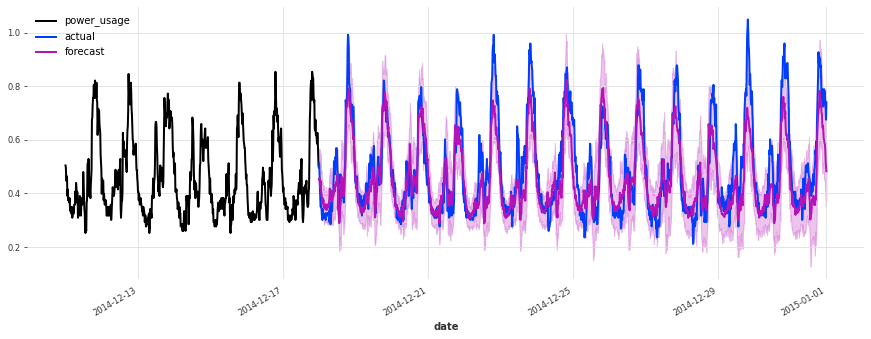

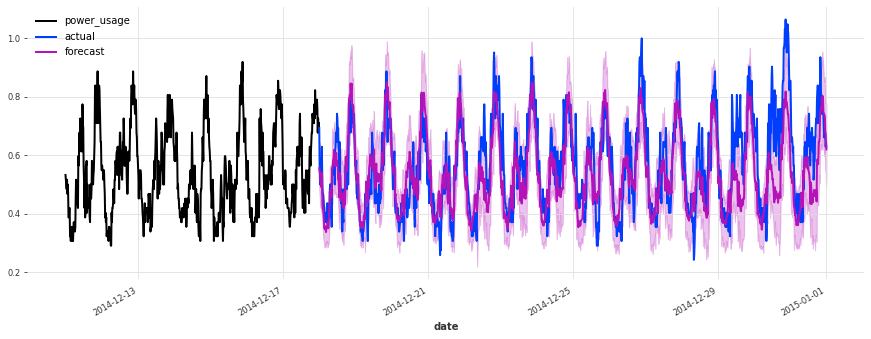

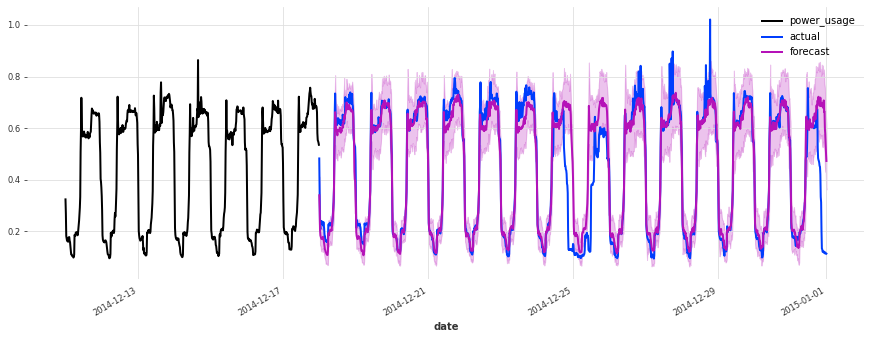

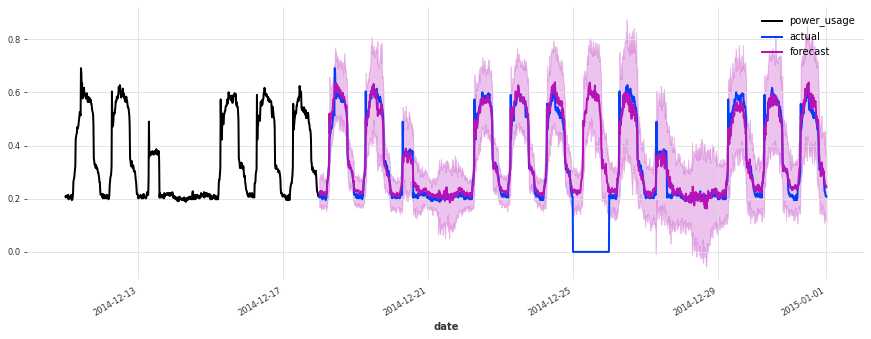

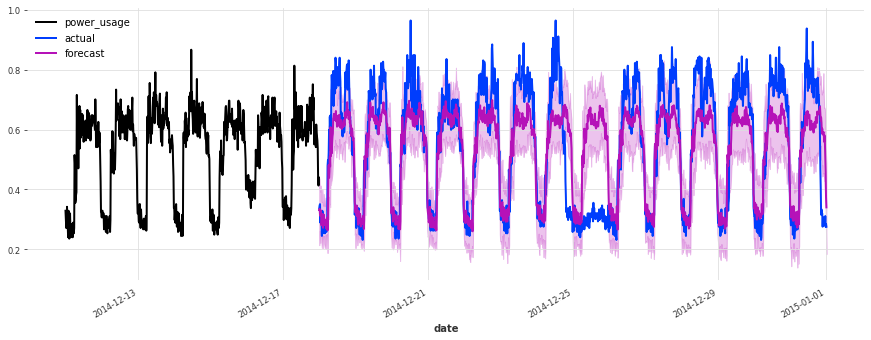

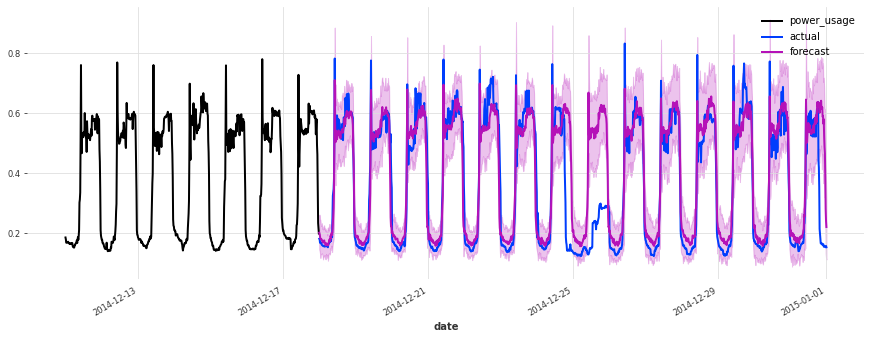

In [50]:
train_val_set = scaler.transform([s[:-val_len] for s in all_series_fp32])

best_preds_test = best_model.predict(
    series=train_val_set, n=val_len, num_samples=100, mc_dropout=True
)

eval_model(
    best_preds_test,
    "best model, probabilistic, on test set",
    train_set=train_val_set,
    val_set=test,
)

The performance is not as good on the test set, but on closer inspection this seems to be due to the Christmas time, during which some of the clients (unsurprisingly) changed their consumption. Besides the Christmas time, the quality of the forecasts seems roughly on par with what we had during the validation set, which is a good indication that we probably did not overfit our hyperparameter optimization to the validation set.

To improve this model further, it might be a good idea to consider using indicator variables capturing public holidays (which we haven't done here).

As a last experiment, let's see how our linear regression model performs on the test set:

linear regression, on test set sMAPE: 20.07 +- 22.67


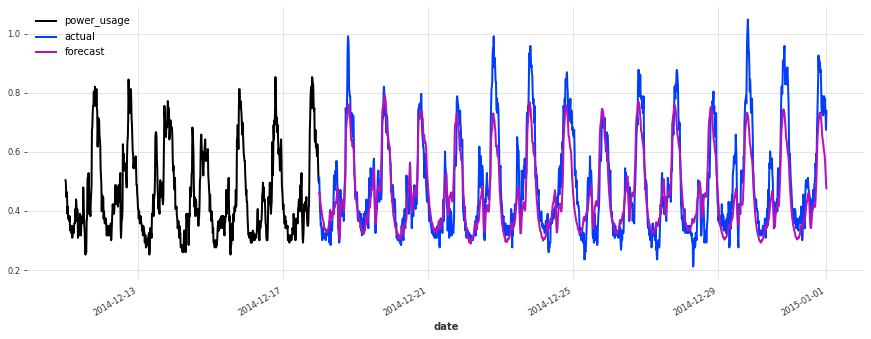

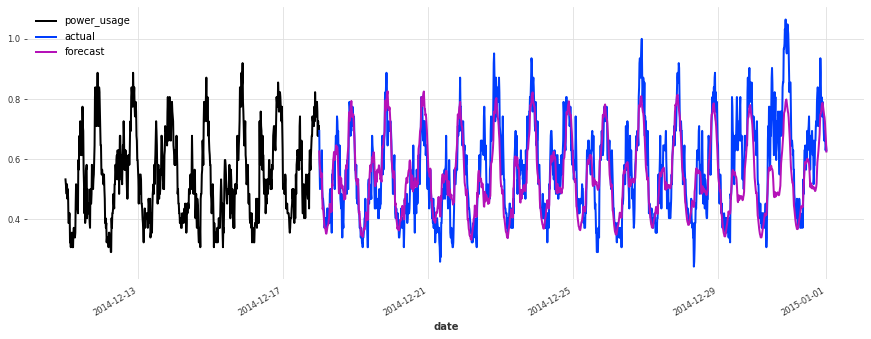

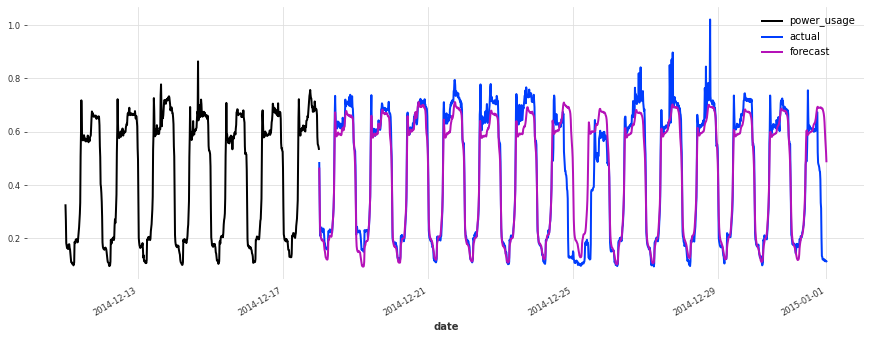

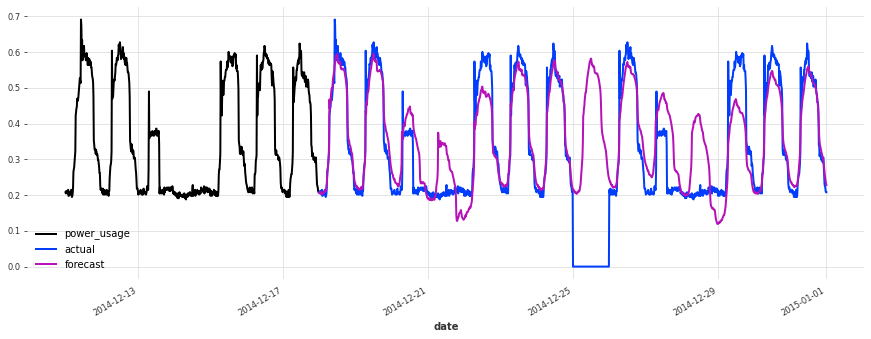

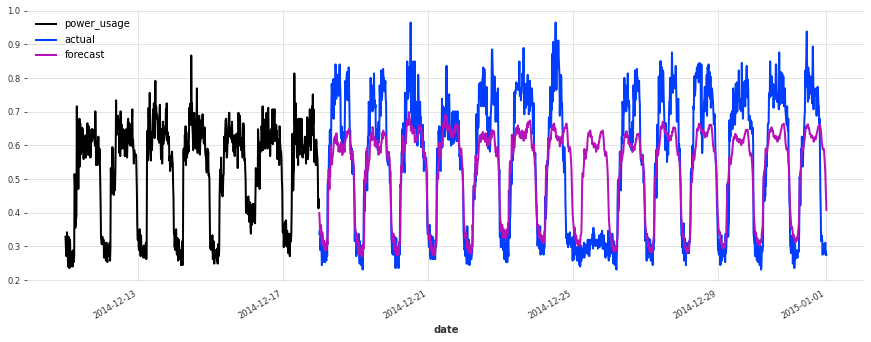

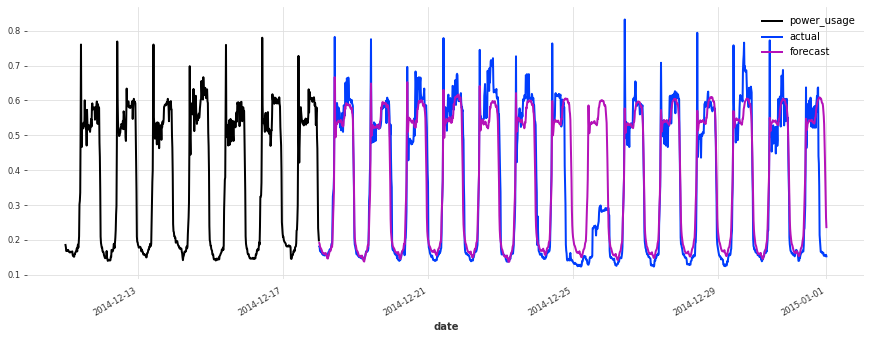

In [43]:
lr_model = LinearRegressionModel(lags=7 * DAY_DURATION)
lr_preds_test = lr_model.predict(series=train_val_set, n=val_len)

eval_model(
    lr_preds_test,
    "linear regression, on test set",
    train_set=train_val_set,
    val_set=test,
)

## Conclusions

We have seen in this notebook that Optuna can be seamlessly used to optimize the hyper-parameters of Darts' models. In fact, there's nothing really particular to Darts when it comes to hyperparameter optimization: Optuna and other libraries can be used as they would with other frameworks. The only thing to be aware of are the PyTorch Ligthning integrations, which are available through Darts.

### Side conclusion: shall we go with linear regression or TCN to forecast electricty consumption?

Both approaches have pros and cons.

**Pros of linear regression:**

* Simplicity
* Does not require scaling
* Speed
* Does not require a GPU
* Often provides good performance out-of-the-box, without requiring tuning

**Cons of linear regression:**

* Can require a significant amount of memory (when used as a global model as here), although there are ways around that (e.g., SGD-based).
* In our setting, it's impractical to train a stochastic version of the `LinearRegression` model, as this would incur too large a computational complexity.

**TCN, pros:**

* Potentially more tuneable and powerful
* Typically lower memory requirements thanks to SGD
* Very rich support to capture stochasticity in different ways, without requiring significantly more computation
* Very fast bulk inference over many time series once the model is trained - especially if using a GPU

**TCN, cons:**

* More hyperparameters, which can take longer to tune and offer more risks of overfitting. It also means that the model is harder to industrialize and maintain
* Will often require a GPU